# Visualizations - Telegram

In [105]:
%pip install trino==0.332.0 trino[sqlalchemy] seaborn polars -e .

Obtaining file:///home/tlouf/ai4trust-observatory
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for ai4trust-observatory (pyproject.toml) ... done
  Created wheel for ai4trust-observatory: filename=ai4trust_observatory-0.1.0-py3-none-any.whl size=1086 sha256=e3c742f2ddb3c1f7ea57591af7c2b2837d2aaa963328360a968edf2b702dc4d0
  Stored in directory: /tmp/pip-ephem-wheel-cache-jeyt42ed/wheels/98/75/4e/9110b380ce8b38b12341052a9e4c1ea580fe4e1e547aee4302
Successfully built ai4trust-observatory
Note: you may need to restart the kernel to use updated packages.


In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
import trino.dbapi
import os 
import polars as pl
import datetime as dt
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
from pathlib import Path

import ai4trust_observatory as obs

In [3]:
TRINO_HOST=os.environ.get("TRINO_HOST")
TRINO_USER=os.environ.get("TRINO_USER")

In [ ]:
def _json_default(value):
    if isinstance(value, (dt.datetime, dt.date)):
        return value.isoformat()
    else:
        return repr(value)


def save_dict(d, path):
    path.write_text(json.dumps(d, default=_json_default))


def load_dict(path):
    plot_d = json.loads(path.read_text())
    return plot_d


def df_from_data_d(data_d):
    return pl.DataFrame(data_d, schema_overrides={"date": pl.Datetime})


def plot_from_d(plot_d: dict, ax, **kwargs):
    df = df_from_data_d(plot_d["data"])
    if plot_d["chart_type"] == "bar":
        ax.bar(x=plot_d["x_data"], height=plot_d["y_data"], data=df, **kwargs)
    elif plot_d["chart_type"] == "line":
        ax.plot(x=plot_d["x_data"], y=plot_d["y_data"], data=df, **kwargs)
    elif plot_d["chart_type"] == "scatter":
        ax.scatter(x=plot_d["x_data"], y=plot_d["y_data"], data=df, **kwargs)
    ax.set_xlabel(plot_d.get("xlabel"))
    ax.set_ylabel(plot_d.get("ylabel"))
    ax.set_title(plot_d.get("title"))
    ax.set_xscale(plot_d.get("yscale", "linear"))
    ax.set_yscale(plot_d.get("xscale", "linear"))
    return ax

In [4]:
with trino.dbapi.connect(host=TRINO_HOST, user=TRINO_USER, catalog='iceberg') as conn:
    cur = conn.cursor()
    # cur.execute('describe telegram.channel_metadata')
    cur.execute('describe telegram.messages')
    a = cur.description
    schema = cur.fetchall()
    cur.close()
schema

[['noforwards', 'boolean', '', ''],
 ['about', 'varchar', '', ''],
 ['pinned_msg_id', 'bigint', '', ''],
 ['signatures', 'boolean', '', ''],
 ['stargifts_available', 'boolean', '', ''],
 ['call_not_empty', 'boolean', '', ''],
 ['stories_hidden', 'boolean', '', ''],
 ['id', 'bigint', '', ''],
 ['_timestamp', 'bigint', '', ''],
 ['has_link', 'boolean', '', ''],
 ['participants_count', 'bigint', '', ''],
 ['document_count', 'bigint', '', ''],
 ['gigagroup', 'boolean', '', ''],
 ['participants_hidden', 'boolean', '', ''],
 ['left', 'boolean', '', ''],
 ['can_view_stars_revenue', 'boolean', '', ''],
 ['broadcast', 'boolean', '', ''],
 ['stories_pinned_available', 'boolean', '', ''],
 ['view_forum_as_messages', 'boolean', '', ''],
 ['scam', 'boolean', '', ''],
 ['join_to_send', 'boolean', '', ''],
 ['url_count', 'bigint', '', ''],
 ['megagroup', 'boolean', '', ''],
 ['unread_count', 'bigint', '', ''],
 ['min', 'boolean', '', ''],
 ['blocked', 'boolean', '', ''],
 ['can_view_stats', 'boolean'

# Volume

## Data ingestion

In [44]:
query = """
with date_count as (
    select id, cast(from_iso8601_timestamp(date) as DATE) as date
    from telegram.messages
)
select date, count(*) as message_count from date_count group by date
"""
volume_df = obs.db_utils.df_from_db(query)

In [82]:
query = """
with date_count as (
    select id, date_trunc('DAY', from_iso8601_timestamp(date)) as date
    from telegram.messages
)
select date, count(*) as message_count from date_count group by date
"""
volume_df = obs.db_utils.df_from_db(query)

## Messages volume plot

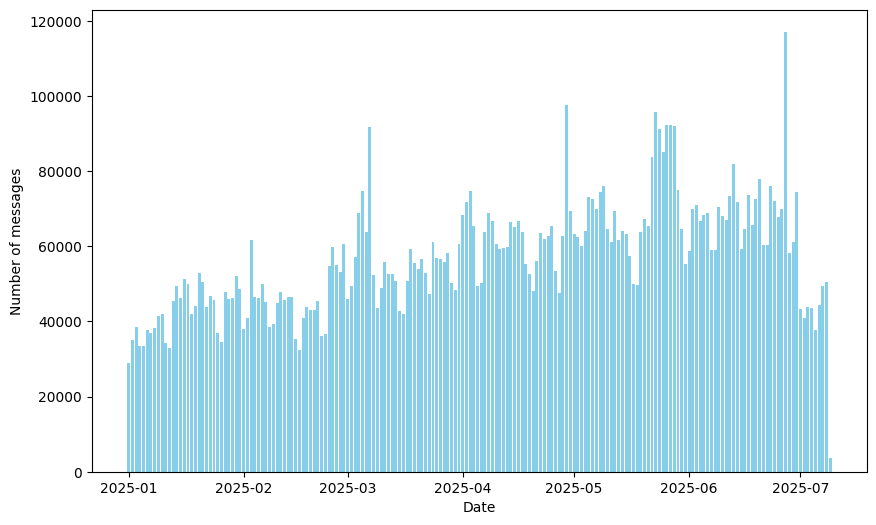

In [83]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x='date', height='message_count', data=volume_df, color='skyblue')
ax.set_xlabel('Date')
ax.set_ylabel('Number of messages')
fig.show()

### IO

In [72]:
plot_path = Path('daily_message_counts.json')

In [77]:
plot_d = {'data': volume_df.to_dict(as_series=False)}
plot_d['title'] = 'Daily number of messages'
plot_d['xlabel'] = 'Date'
plot_d['ylabel'] = 'Number of messages'
plot_d['x_data'] = 'date'
plot_d['y_data'] = 'message_count'
plot_d['chart_type'] = 'bar'
plot_d['platform'] = 'Telegram'

save_dict(plot_d, plot_path)

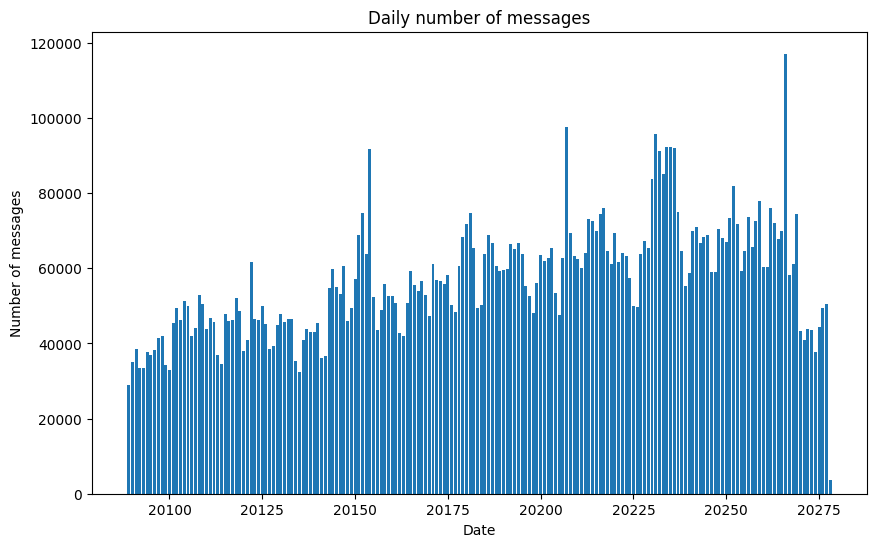

In [99]:
plot_d = load_dict(plot_path)
fig, ax = plt.subplots(figsize=(10, 6))
ax = plot_from_d(plot_d, ax)
fig.show()

# Disinfo risk

## Data ingest

In [5]:
query = "select * from news.lasser_dq_scores"
domains = obs.db_utils.df_from_db(query, catalog='db').rename({'pc1': 'reliability'})

In [9]:
dt_range = pl.datetime_range(
    dt.date(2025, 1, 1),
    dt.date.today() - dt.timedelta(days=2),
    eager=True,
    interval="1w",
)
eng_cols = ["views", "nr_replies", "forwards", 'reactions']
cols = ["peer_id", "id", "date", "text_urls", 'other_reactions'] + eng_cols
domain_patt = r"^(?:https?:\/\/)?(?:www\.)?([^:\/\n?]+)"

IRI:

numerator = sum over channels(sum over urls((1-reliability) * views/forwards/replies/reactions...))

denominator = sum over channels(sum over urls(views/forwards/replies/reactions...))

Elisa's is same as above with the channel sum, she basically gets weighted average of unreliability by channel.

In [121]:
start_from_idx = 0  # to resume after a crash
stats_evol = []
for i, (dt_from, dt_to) in tqdm(enumerate(zip(dt_range[start_from_idx:-1], dt_range[start_from_idx + 1 :]))):
    query = (
        f"select {', '.join(cols)} from telegram.messages"
        f" where date > '{dt_from}' and date < '{dt_to}' and cardinality(text_urls) > 0"
    )
    df = obs.db_utils.df_from_db(query, struct_cols=["reactions"], infer_schema_length=None)
    if df.is_empty():
        continue
    df = (
        df.with_columns(
            reactions=pl.col("other_reactions").fill_null(0)
            + pl.sum_horizontal(pl.col("reactions").struct.unnest())
        )
        .explode("text_urls")
        .with_columns(pl.col("text_urls").str.extract(domain_patt).alias("domain"))
        .join(domains, on="domain", how="left")
    )
    stats = df.select(
        pl.lit(dt_from).alias("date"),
        pl.col("reliability").mean().alias("mean_rel"),
        url_count=pl.len(),
        prop_tg=(pl.col("domain") == "t.me").sum() / pl.len(),
        prop_labelled=pl.col("reliability").is_not_null().sum() / pl.len(),
    )
    iri = df.filter(pl.col("reliability").is_not_null()).select(
        (
            (pl.col(*eng_cols) * (1 - pl.col("reliability"))).sum()
            / (pl.col(*eng_cols).sum())
        ).name.prefix("iri_")
    )
    stats_evol.append({**stats.to_dicts()[0], **iri.to_dicts()[0]})
    if i > 2:
        break


0it [00:00, ?it/s]

3it [00:36, 12.21s/it]


In [122]:
stats_evol = pl.DataFrame(stats_evol, orient="row")

## URL volume plot

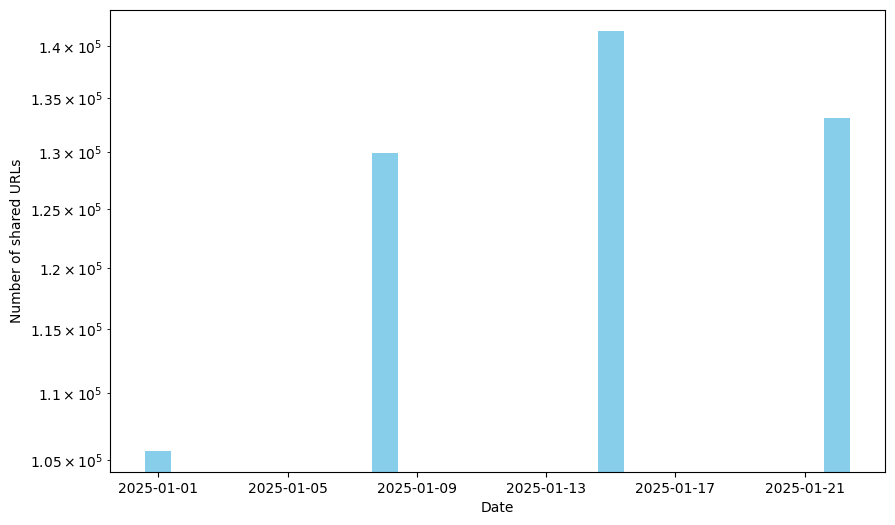

In [123]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x='date', height='url_count', data=stats_evol, color='skyblue')
ax.set_xlabel('Date')
ax.set_ylabel('Number of shared URLs')
ax.set_yscale('log')
fig.show()

### IO

In [124]:
plot_path = Path('weekly_url_counts.json')

In [125]:
plot_d = {'data': stats_evol.to_dict(as_series=False)}
plot_d['title'] = 'Weekly number of shared URLs'
plot_d['xlabel'] = 'Date'
plot_d['ylabel'] = 'Number of shared URLs'
plot_d['yscale'] = 'log'
plot_d['x_data'] = 'date'
plot_d['y_data'] = 'url_count'
plot_d['chart_type'] = 'bar'
plot_d['platform'] = 'Telegram'

save_dict(plot_d, plot_path)

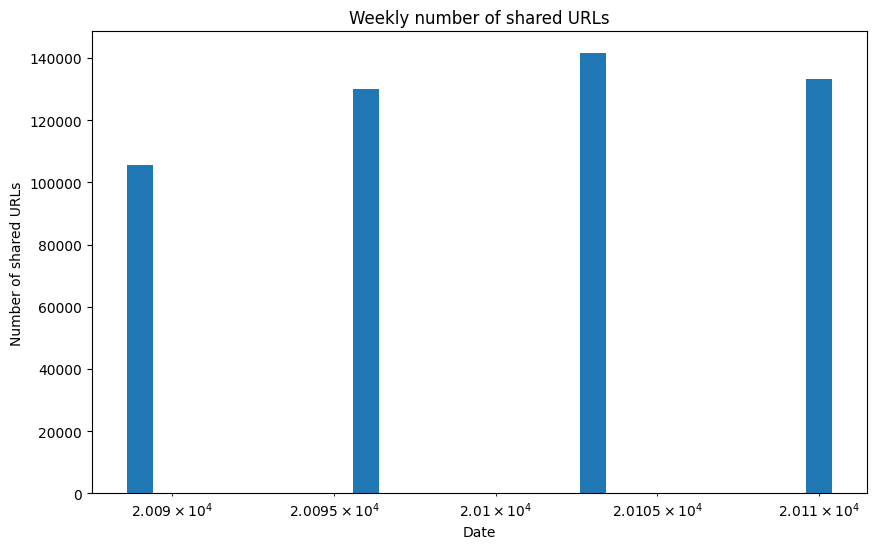

In [126]:
plot_d = load_dict(plot_path)
fig, ax = plt.subplots(figsize=(10, 6))
plot_from_d(plot_d, ax)
fig.show()

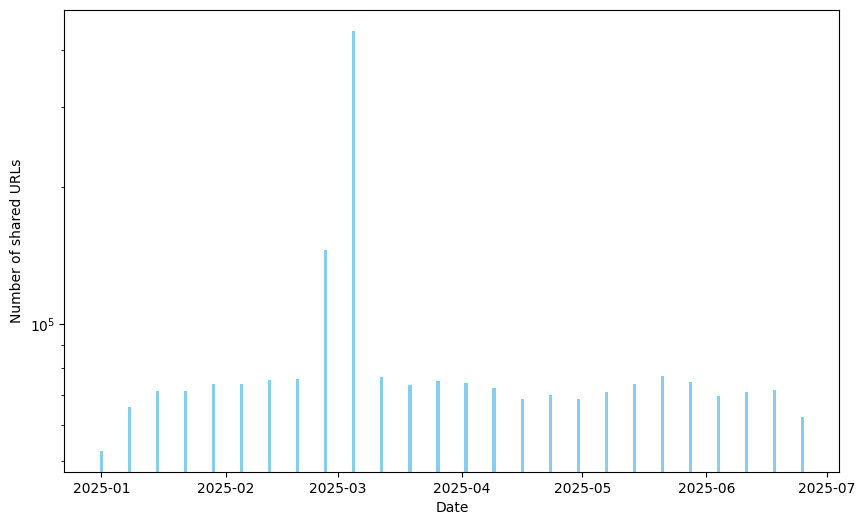

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x='date', height='url_count', data=stats_evol, color='skyblue')
ax.set_xlabel('Date')
ax.set_ylabel('Number of shared URLs')
ax.set_yscale('log')
fig.show()

## Other plots

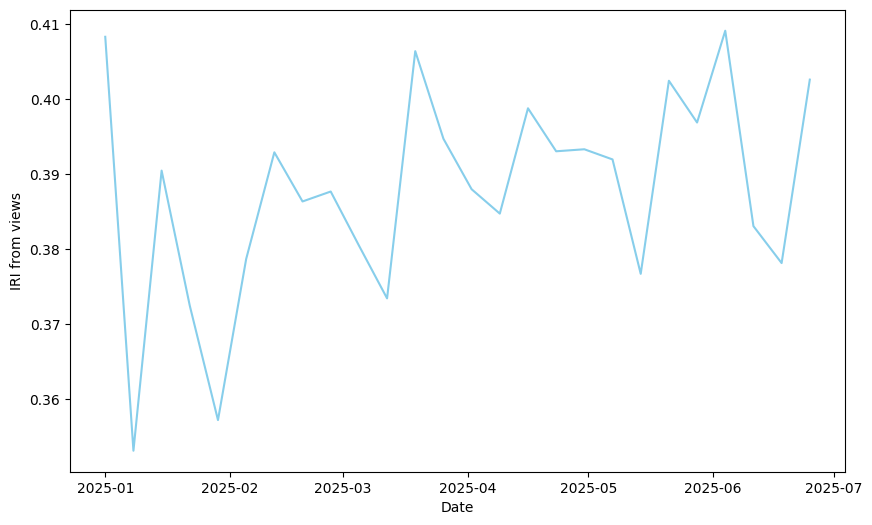

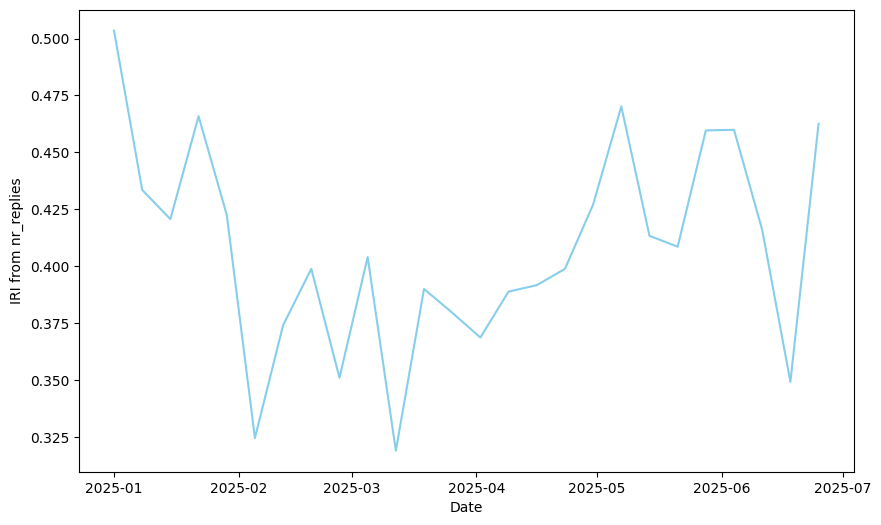

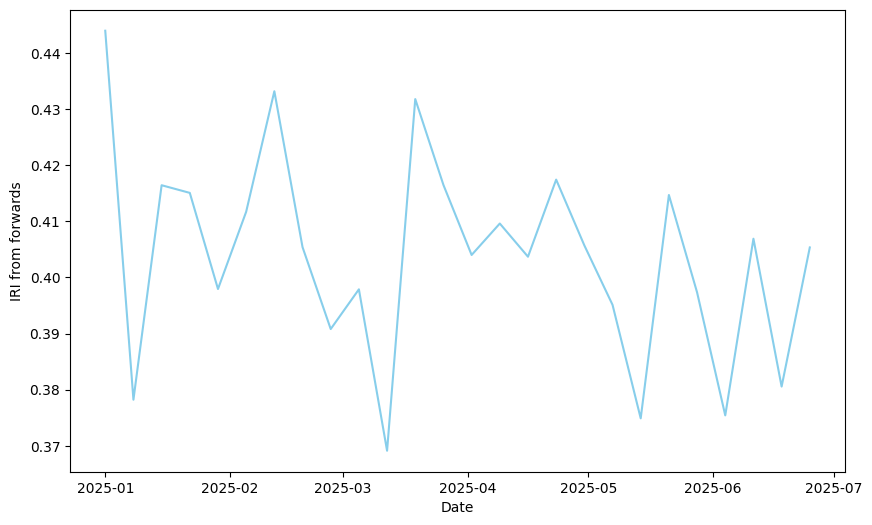

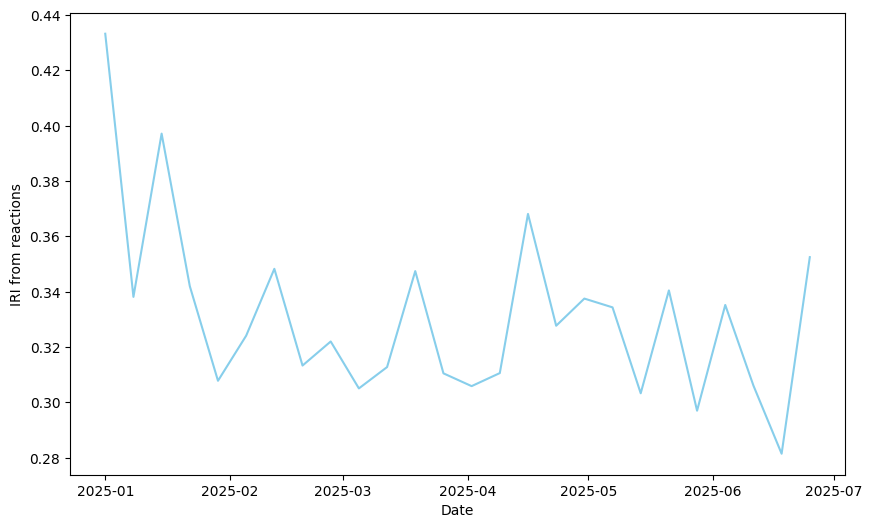

In [23]:
for eng_type in eng_cols:
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot('date', f'iri_{eng_type}', data=stats_evol, color='skyblue')
    ax.set_xlabel('Date')
    ax.set_ylabel(f'IRI from {eng_type}')
    fig.show()

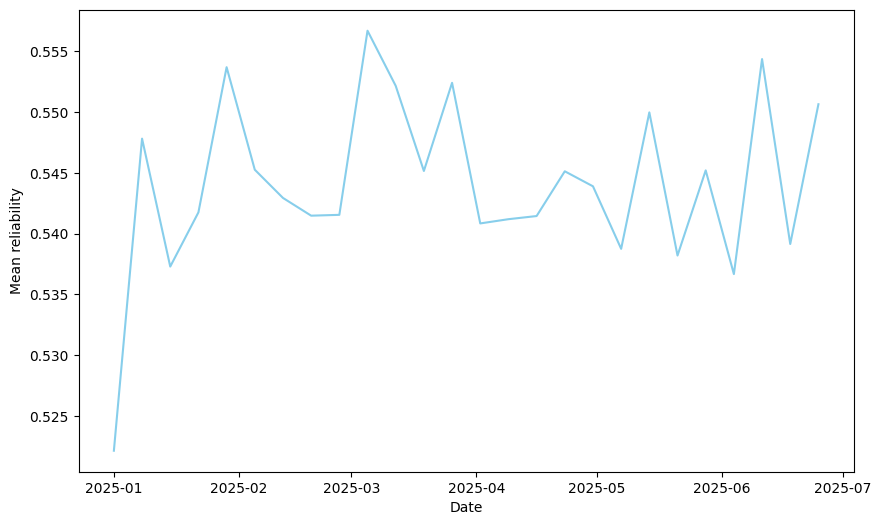

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot('date', 'mean_rel', data=stats_evol, color='skyblue')
ax.set_xlabel('Date')
ax.set_ylabel('Mean reliability')
fig.show()

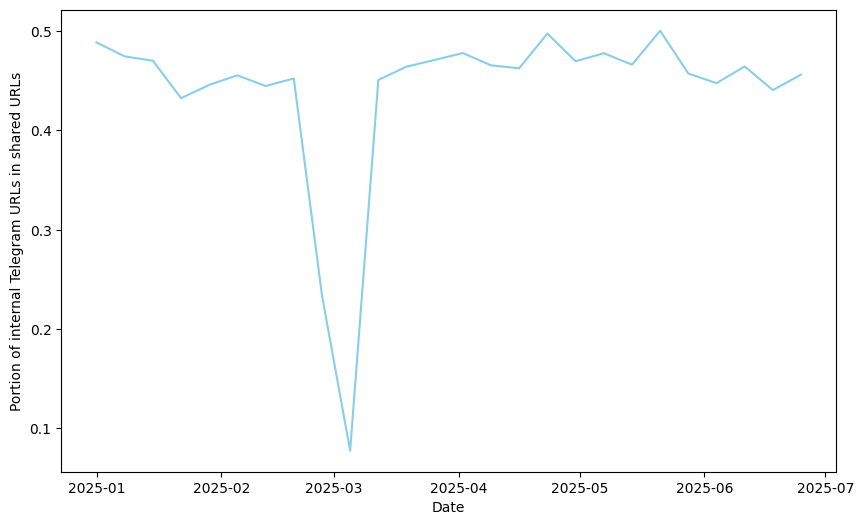

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot('date', 'prop_tg', data=stats_evol, color='skyblue')
ax.set_xlabel('Date')
ax.set_ylabel('Portion of internal Telegram URLs in shared URLs')
fig.show()

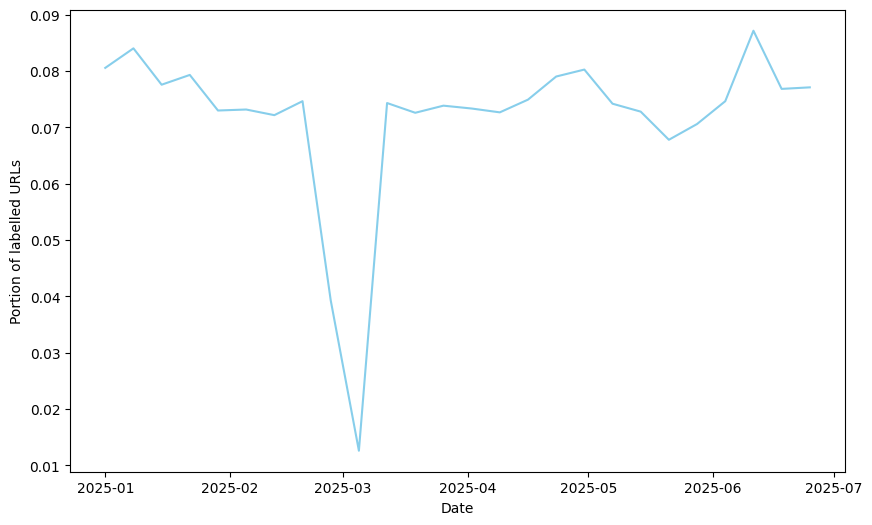

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot('date', 'prop_labelled', data=stats_evol, color='skyblue')
ax.set_xlabel('Date')
ax.set_ylabel('Portion of labelled URLs')
fig.show()

# Check tools output for TG

In [ ]:
with trino.dbapi.connect(host=TRINO_HOST, user=TRINO_USER, catalog='iceberg') as dc_conn:
    cur = dc_conn.cursor()
    a = cur.execute("select * from tools.text_disinformation_signals_detection limit 5").fetchall()

In [ ]:
a[0][3][0]